#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
plt.rcParams["figure.figsize"] = (12,6)
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('taxi.csv')

In [3]:
data.info()
print(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32
5  2018-03-01 00:50:00          21
6  2018-03-01 01:00:00           7
7  2018-03-01 01:10:00           5
8  2018-03-01 01:20:00          17
9  2018-03-01 01:30:00          12


In [4]:
print(data.duplicated().sum())

0


In [5]:
print(data['num_orders'].describe())

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64


По диаграмме размаха межквартильный интервал +- 3 сигмы нижняя граница покрывает весь размах наблюдений, верхняя - 52. Значения больше 80 удалены - выбросы.

In [6]:
data = data.loc[data['num_orders'] <= 80]

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.index = data['datetime']
data = data.drop('datetime', axis=1)
print(data.index.is_monotonic)

True


/var/folders/33/ny68z_j90c57fxzbyfchcgk00000gp/T/ipykernel_16250/72321954.py:4: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(data.index.is_monotonic)


In [8]:
data = data.resample('1H').sum()

В данных явных ошибок не обнаружено, дубликатов не выявлено. Выполнено ресемплирование по одному часу.

## Анализ

In [9]:
print(data['num_orders'].describe())

count    4416.000000
mean       84.183877
std        43.958801
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       295.000000
Name: num_orders, dtype: float64


In [10]:
data['rolling_mean'] = data['num_orders'].shift().rolling(5).mean()

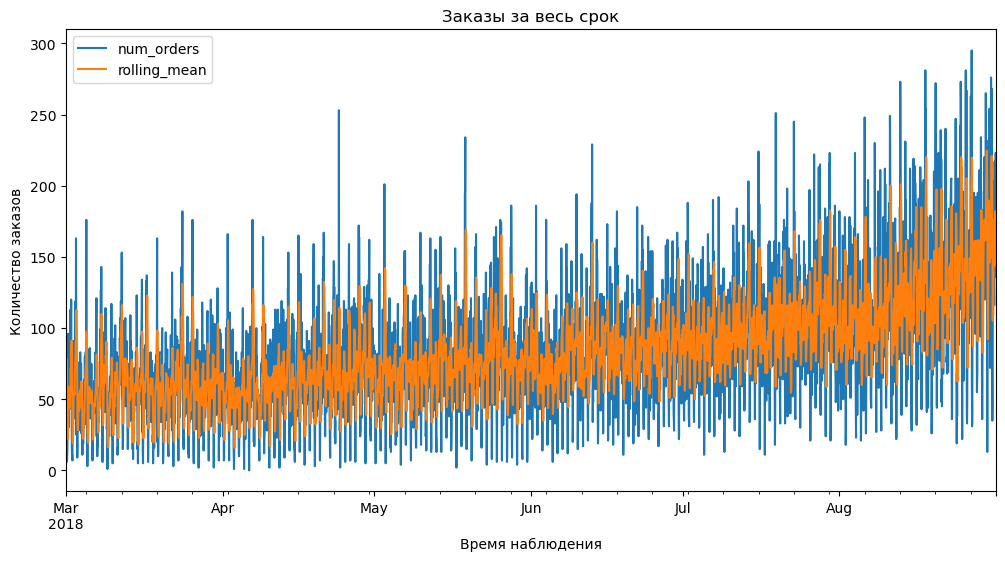

In [11]:
data.plot(title='Заказы за весь срок')
plt.xlabel('Время наблюдения')
plt.ylabel('Количество заказов')
plt.show()

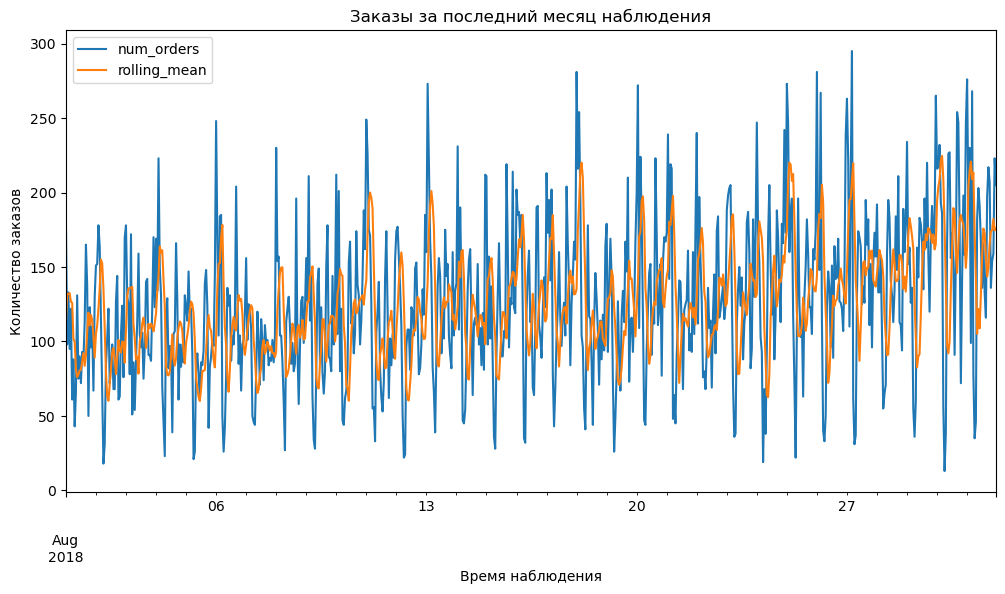

In [12]:
data['2018-08-01':'2018-08-31'].plot(title='Заказы за последний месяц наблюдения')
plt.xlabel('Время наблюдения')
plt.ylabel('Количество заказов')
plt.show()

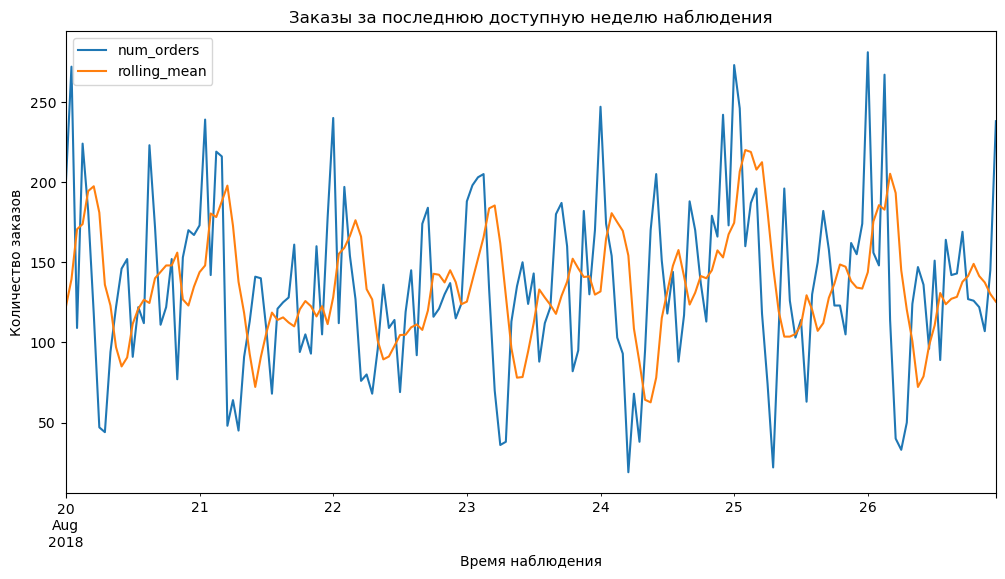

In [13]:
data['2018-08-20':'2018-08-26'].plot(title='Заказы за последнюю доступную неделю наблюдения')
plt.xlabel('Время наблюдения')
plt.ylabel('Количество заказов')
plt.show()

/var/folders/33/ny68z_j90c57fxzbyfchcgk00000gp/T/ipykernel_16250/2227908873.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data['2018-08-31'].plot(title='Заказы за последний день наблюдения')


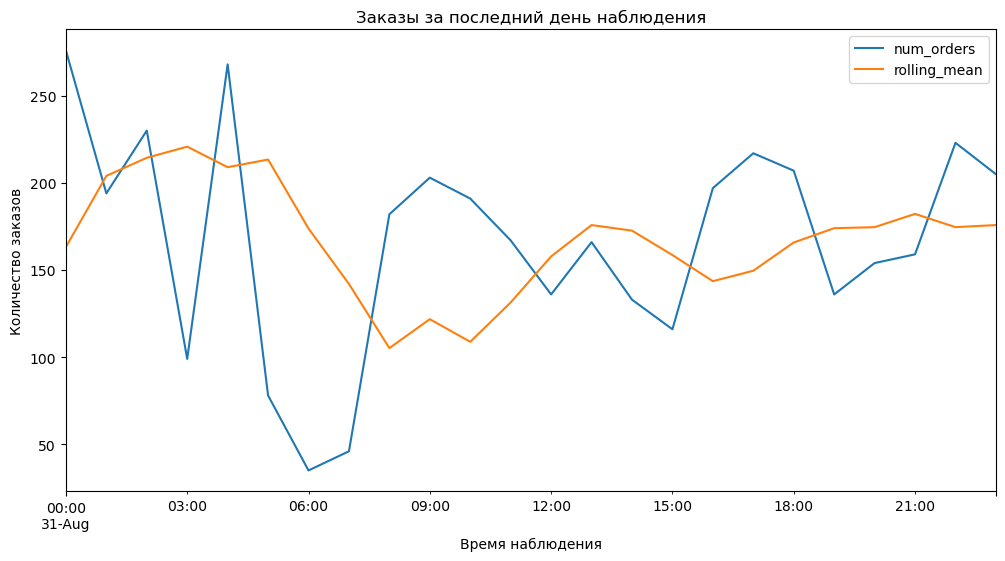

In [14]:
data['2018-08-31'].plot(title='Заказы за последний день наблюдения')
plt.xlabel('Время наблюдения')
plt.ylabel('Количество заказов')
plt.show()

In [15]:
data = data.drop(columns=['rolling_mean'], axis=1)

In [16]:
data.isnull().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 198.0 KB


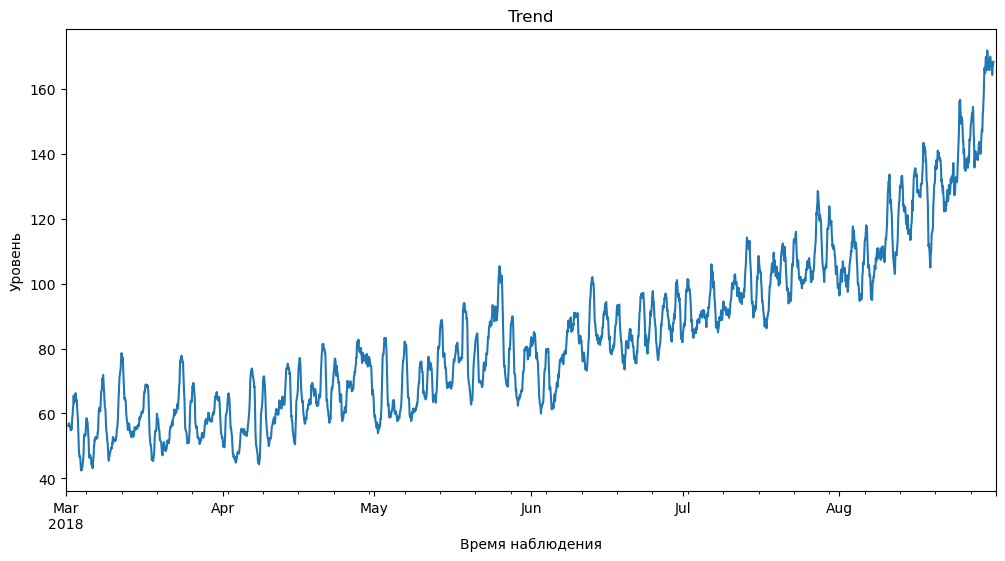

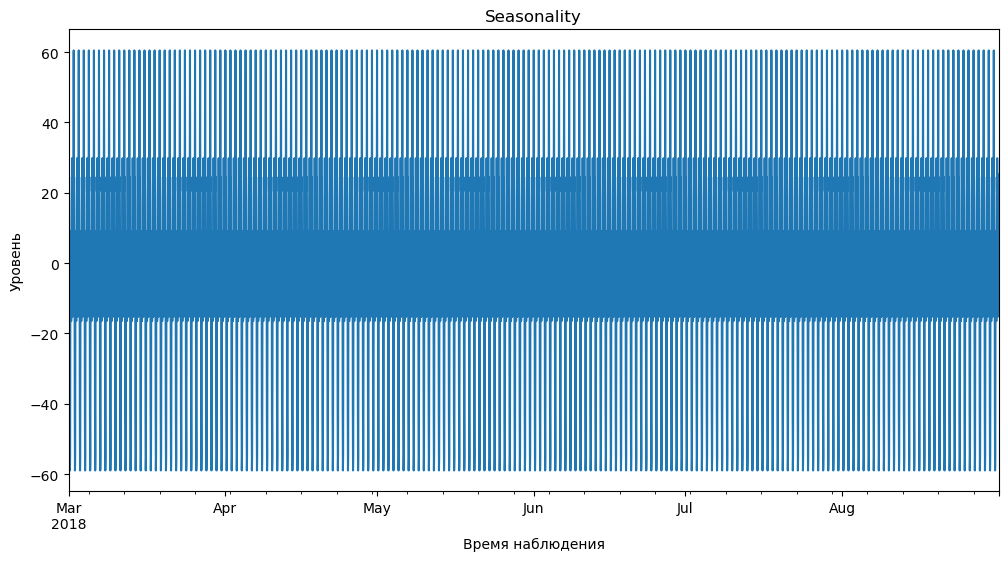

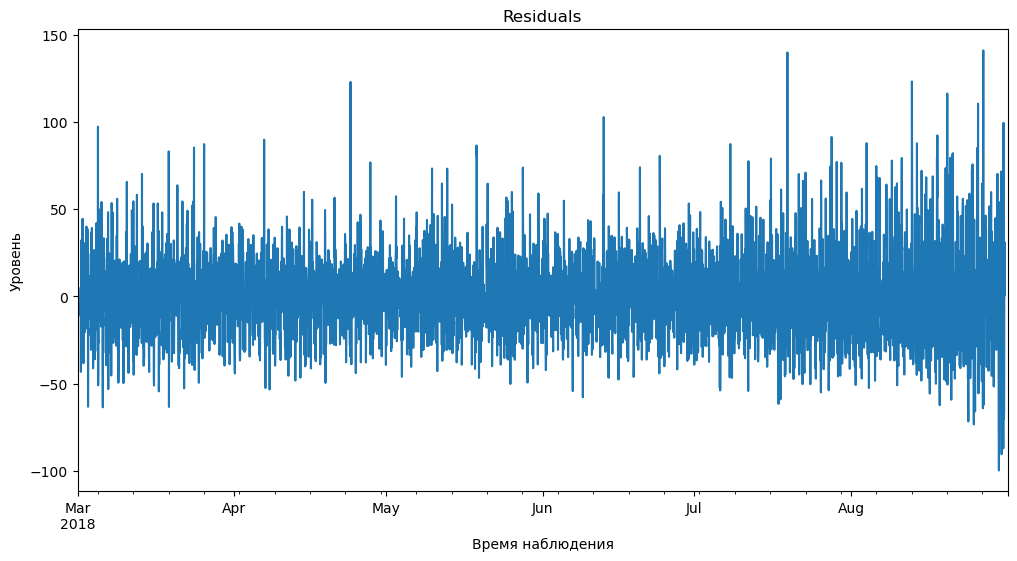

In [17]:
decomposed = seasonal_decompose(data)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Время наблюдения')
plt.ylabel('Уровень')
plt.show()

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Время наблюдения')
plt.ylabel('Уровень')
plt.show()

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Время наблюдения')
plt.ylabel('Уровень')
plt.show()

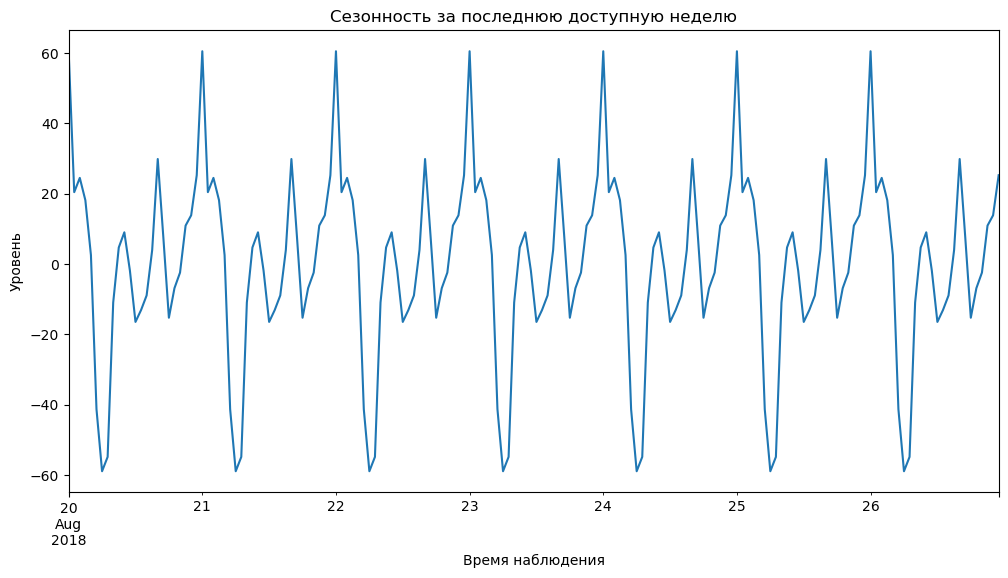

In [18]:
decomposed.seasonal['2018-08-20':'2018-08-26'].plot()
plt.title('Сезонность за последнюю доступную неделю')
plt.xlabel('Время наблюдения')
plt.ylabel('Уровень')
plt.show()

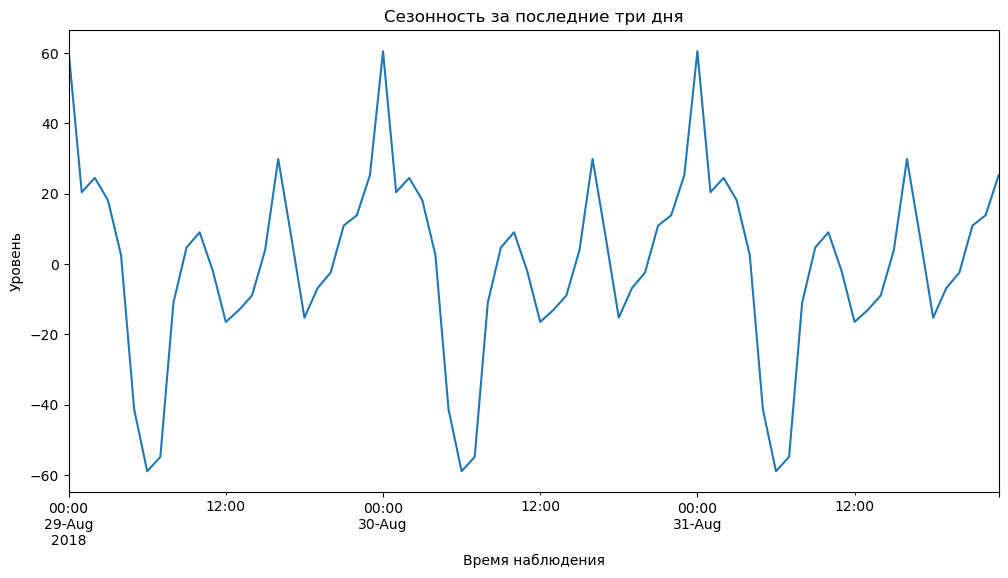

In [19]:
decomposed.seasonal['2018-08-29':'2018-08-31'].plot()
plt.title('Сезонность за последние три дня')
plt.xlabel('Время наблюдения')
plt.ylabel('Уровень')
plt.show()

Данные выглядят правдоподобно. В среднем наблюдается увеличение спроса. Проглядываются пики в вечерние и ночные часы и спад в ранние утренние часы. Наблюдается суточная сезонноть. Предположительно пики объясняются времемем прилета-отлёта самолетов. Судя по увеличению скользящего среднего на первом графике, можно сделать вывод, что он нестационарен.

## Обучение

In [20]:
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

In [21]:
rmse = 48
num_lag = 0
rolling_mean_size = 0

for n in range(1, 11):
    for r in range(2,11):
        data_par = data
        data_par['lag_{}'.format(n)] = data_par['num_orders'].shift(n)
        data_par['rolling_mean'] = data_par['num_orders'].shift().rolling(r).mean()
        data_par = data_par.dropna()
        
        train, test = train_test_split(data_par, shuffle=False, test_size=0.1)
        train, valid = train_test_split(train, shuffle=False, test_size=0.25)
        features_train = train.drop(columns=['num_orders'],axis=1)
        target_train = train['num_orders']
        features_valid = valid.drop(columns=['num_orders'],axis=1)
        target_valid = valid['num_orders']
    
        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        rmse1 = mean_squared_error(target_valid, predictions)**0.5
        if rmse1 < rmse:
            rmse = rmse1
            num_lag = n
            rolling_mean_size = r

print('rmse: ', rmse, 'num_lag: ', num_lag, 'rolling_mean_size: ', rolling_mean_size)

rmse:  38.658896259285896 num_lag:  6 rolling_mean_size:  8


In [22]:
for i in range(1,10):
    data['lag_{}'.format(i)] = data['num_orders'].shift(i)
    
data['rolling_mean'] = data['num_orders'].shift().rolling(7).mean()
    
data = data.dropna()

In [23]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train, shuffle=False, test_size=0.25)

In [24]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 10:00:00 2018-07-03 06:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


In [25]:
features_train = train.drop(columns=['num_orders'],axis=1)
target_train = train['num_orders']
features_valid = valid.drop(columns=['num_orders'],axis=1)
target_valid = valid['num_orders']
features_test = test.drop(columns=['num_orders'],axis=1)
target_test = test['num_orders']

In [26]:
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)
predictions = model_linear.predict(features_valid)
rmse_linear = mean_squared_error(target_valid, predictions)**0.5
print('rmse_LinearRegression', rmse_linear)

rmse_LinearRegression 38.78225098200751


In [27]:
rmse_forest = 5000
max_depth = 0
n_estimators = 0

for i in range(1,31):
    for n in range(10,110,10):
        model_forest = RandomForestRegressor(random_state=12345,n_estimators=n, max_depth=i)
        model_forest.fit(features_train, target_train)
        predictions = model_forest.predict(features_valid)
        rmse_forest1 = mean_squared_error(target_valid, predictions)**0.5
        if rmse_forest1 < rmse_forest:
            rmse_forest = rmse_forest1
            max_depth = i
            n_estimators = n
print('max_depth:', max_depth, 'n_estimators:', n_estimators, 'rmse_forest:', rmse_forest)

max_depth: 18 n_estimators: 60 rmse_forest: 29.918806214411134


In [28]:
model_forest = RandomForestRegressor(random_state=12345,n_estimators=60, max_depth=18)
model_forest.fit(features_train, target_train)
predictions = model_forest.predict(features_valid)
rmse_forest = mean_squared_error(target_valid, predictions)**0.5
print('rmse_forest:', rmse_forest)

rmse_forest: 29.918806214411134


In [29]:
model_light = LGBMRegressor(random_state=12345)
model_light.fit(features_train, target_train)
predictions = model_light.predict(features_valid)
rmse_light = mean_squared_error(target_valid, predictions)**0.5
print('rmse_light:', rmse_light)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1964
[LightGBM] [Info] Number of data points in the train set: 2973, number of used features: 14
[LightGBM] [Info] Start training from score 69.944501
rmse_light: 29.7716128928709


Лучшее показатели у LGBMRegressor при скользящем среднем с окном-8 и количеством "отстающих значений"-6.

## Тестирование

In [30]:
model_light.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))
predictions_light_test = model_light.predict(features_test)
rmse_light_test = mean_squared_error(target_test, predictions_light_test)**0.5
print('rmse_light_test:', rmse_light_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2228
[LightGBM] [Info] Number of data points in the train set: 3965, number of used features: 14
[LightGBM] [Info] Start training from score 78.306683
rmse_light_test: 41.05964092708424


In [31]:
predictions_mean = pd.Series(target_train.mean(), index=target_test.index)
rmse_mean = mean_squared_error(target_test, predictions_mean)**0.5
print(rmse_mean)

86.7638708315637


In [32]:
predictions_lag = features_test['lag_1']
rmse_lag = mean_squared_error(target_test, predictions_lag)**0.5
print(rmse_lag)

55.83529796523175


При прогнозировании средним числом и предыдушим значением качество предсказания гораздо хуже (65.01 и 45.59 соответственно) по сравнению с обученной моделью (41.49).

    Вывод: В ходе проекта были получены данные о заказах такси в аэропортах. Нужно было спрогнозировать количество заказов на следующий час. Данные были проанализированы, значительной обработки не понадобилось. Были созданы дополнительные признаки. Затем подобраны оптимальные параметры и модель проверена на одекватность. Лучшей оказалась LGBMRegressor (при скользящем среднем с окном-7 и количеством "отстающих значений"-6. (выполнено условие: не больше 48)).